In [1]:
import os, sys

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

from sklearn.utils.extmath import row_norms
from sklearn.metrics.pairwise import _euclidean_distances


project_dir = os.path.abspath("..")
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

from yace.run_worker import JobInfo

In [2]:
def get_raw_results(file_paths):
    data_frames = []
    for index, job_info_path in enumerate(file_paths):
        job_info = JobInfo.load_json(job_info_path)
        experiment_type = job_info.command_params["experiment-type"]
        working_dir = job_info_path.parent
        duration_secs = int((job_info.completed_at - job_info.started_at).total_seconds())
        
        distortions_paths = list(working_dir.glob("distortions*.feather"))
        if len(distortions_paths) == 0:
            continue

        df_perf_data = pd.concat([
            pd.read_feather(file_path)
            for file_path in distortions_paths
        ])
        df_perf_data["experiment_id"] = working_dir.name
        df_perf_data["experiment_type"] = experiment_type
        df_perf_data["running_time_secs"] = duration_secs
        df_perf_data["job_info_path"] = job_info_path
        
        for param, val in job_info.experiment_params.items():
            df_perf_data[f"{param}"] = val
        
        data_frames.append(df_perf_data)
    df_data = pd.concat(data_frames)
    return df_data

def add_combined_mean_std(df: pd.DataFrame, attr: str):
    def combiner(row) -> str:
        mean = row[f"{attr}_mean"]
        std =  row[f"{attr}_std"]
        return f"{mean:0.4f} ({std:0.5f})"
    df[f"{attr}_mean_std"] = df.apply(lambda x: combiner(x), axis=1)


In [3]:
data_results_dir = Path("../data/experiments-odin/rw/")

In [4]:
job_info_paths = list(Path("../data/experiments-odin/rw/").glob("**/job-info.json"))

In [5]:
df_raw_results = get_raw_results(job_info_paths)

In [6]:
df_raw_results = df_raw_results[df_raw_results["solution_type"] == "kmeans++-on-coreset"].copy()

In [7]:
grouping_cols = ["data_set", "k", "algorithm_name", "coreset_size", "solution_type"]
aggregation_spec = dict(
    distortion_mean=("distortion", np.mean),
    distortion_std=("distortion", np.std),
    n_solutions=("distortion", "count")
)
df_grouped = df_raw_results.groupby(grouping_cols).agg(**aggregation_spec).reset_index()
df_grouped

,data_set,k,algorithm_name,coreset_size,solution_type,distortion_mean,distortion_std,n_solutions
0,census,10,sensitivity-sampling,2000,kmeans++-on-coreset,1.140138,0.075736,10
1,census,10,uniform-sampling,2000,kmeans++-on-coreset,1.056618,0.025964,10
2,census,20,sensitivity-sampling,4000,kmeans++-on-coreset,1.105788,0.045367,10
3,census,20,uniform-sampling,4000,kmeans++-on-coreset,1.053856,0.039792,10
4,census,30,sensitivity-sampling,6000,kmeans++-on-coreset,1.039499,0.035433,10
5,census,30,uniform-sampling,6000,kmeans++-on-coreset,1.037758,0.021773,10
6,census,40,sensitivity-sampling,8000,kmeans++-on-coreset,1.024242,0.014021,10
7,census,40,uniform-sampling,8000,kmeans++-on-coreset,1.015738,0.006689,10
8,census,50,sensitivity-sampling,10000,kmeans++-on-coreset,1.034964,0.033937,10
9,census,50,uniform-sampling,10000,kmeans++-on-coreset,1.018261,0.009676,10


In [8]:
# pd.pivot(data=df_grouped, index=["data_set", "k"], columns=["algorithm_name"], values="distortion_mean")

In [9]:
colors = sns.color_palette("tab10")
colors = sns.color_palette("bright")
algorithms = np.sort(df_raw_results.algorithm_name.unique())[::-1]
algorithm_colors = {algo: colors[i] for i, algo in enumerate(algorithms)}
df_raw_results["k_formatted"] = "$k$=" + df_raw_results["k"].astype(str)
df_grouped["k_formatted"] = "$k$=" + df_grouped["k"].astype(str)

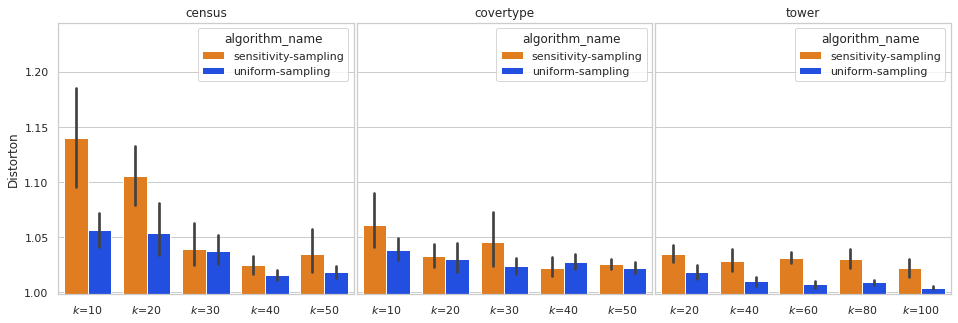

In [10]:
solution_types = df_raw_results["solution_type"].unique()
data_sets = np.sort(df_raw_results["data_set"].unique())
n_rows = len(solution_types)
n_cols = len(data_sets)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=True, figsize=(16, 5))

for i, solution_type in enumerate(solution_types):
    for j, data_set in enumerate(data_sets):
        ax = axes[j] # axes[i,j]
        f1 = df_raw_results["solution_type"] == solution_type
        f2 = df_raw_results["data_set"] == data_set
        df_filtered = df_raw_results[f1&f2].copy()
        df_filtered.sort_values(by=["k", "algorithm_name"], inplace=True)
        sns.barplot(data=df_filtered, x="k_formatted", y="distortion", hue="algorithm_name", ax=ax, palette=algorithm_colors)
        ax.set_ylim(bottom=0.998)
        ax.set_title(f"{data_set}")
        ax.set_ylabel(f"Distorton")
        ax.set_xlabel("")
        if j > 0:
            ax.set_ylabel("")            
        if i == 0:
            ax.set_xlabel("")
fig.subplots_adjust(wspace=0.01)
# fig.savefig("distortions-real-world-v3.pdf", )

## Weight distribution

In [11]:
def get_weights(df_data, data_set: str="census", k: int=10):
    results = []
    for algo in ['uniform-sampling', 'sensitivity-sampling']:
        f1 = df_data["solution_type"] == "kmeans++-on-coreset"
        f2 = df_data["data_set"] == data_set
        f3 = df_data["algorithm_name"] == algo
        f4 = df_data["k"] == k
        
        df_filtered = df_data[f1&f2&f3&f4].copy()
        
        job_info_path = df_filtered.sample(1)["job_info_path"].iloc[0]
        weights = np.load(job_info_path.parent / "coreset-weights.npz")["matrix"]
        results.append(weights)
    return results[0], results[1]

In [12]:
us_coreset_weights, ss_coreset_weights = get_weights(df_data=df_raw_results, data_set="census", k=10)

In [13]:
ss_coreset_weights.mean()

1229.1425

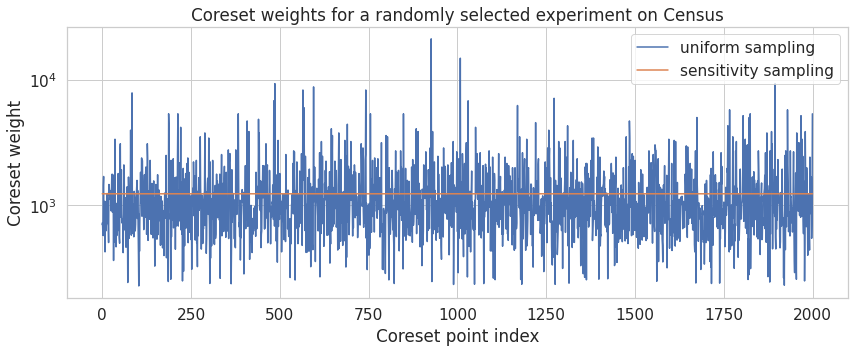

In [14]:
with sns.plotting_context("notebook", font_scale=1.4):
    a = np.arange(ss_coreset_weights.shape[0])
    fig, ax = plt.subplots(figsize=(14, 5))
    sns.lineplot(x=a, y=ss_coreset_weights, label="uniform sampling", ax=ax)
    sns.lineplot(x=a, y=us_coreset_weights, label="sensitivity sampling", ax=ax)
    ax.set_yscale("log")
    ax.set_ylabel("Coreset weight")
    ax.set_xlabel("Coreset point index")
    ax.set_title("Coreset weights for a randomly selected experiment on Census")